## Libraries and data Loading

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import pytz

from multivariateGCI_mr import MultivariateGCI_mr
from multivariateGCI_sr import MultivariateGCI_sr

from qiskit import QuantumRegister, QuantumCircuit, Aer, execute, IBMQ, transpile
from qiskit.utils import QuantumInstance
from qiskit.algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit.providers.aer.noise import NoiseModel
from qiskit.circuit.library import LinearAmplitudeFunction, PhaseEstimation, QFT, GroverOperator

In [35]:
df = pd.read_csv("Data/sampled_counterparts.csv")
# df = df[((df['pd']>=0.1) & ((1000 < df['lgd dwt']*df['ead']) & (df['lgd dwt']*df['ead'] < 5000000)))]
df =  df.iloc[[38-2, 260-2]] #df.iloc[[38-2, 260-2, 7816-2]] 

F_matrix = pd.read_csv("Data/F_for_sampled_counterparts.csv")
sectors = [1] #[1, 2]
F_values = [[F_matrix.iloc[df.index.values[j]][i-1] for i in sectors] for j in range(len(df))]
# F_values = [[0.55], [0.65], [0.50]] # make F/rhos

## Parameters setting

In [36]:
# set problem parameters
n_z = 2
z_max = 2

p_zeros = [el['pd'] for _, el in df.iterrows()]
rhos = [el['is']**2 for _, el in df.iterrows()]
lgd = [el['lgd dwt']*el['ead'] for _, el in df.iterrows()]

K = len(p_zeros)

alpha_var = 0.05

print(f'F: {F_values}\nRhos: {np.sqrt(rhos)}\nLgds: {lgd}\np_zeros: {p_zeros}')
df

F: [[0.1580707722], [0.2555327991]]
Rhos: [0.3 0.3]
Lgds: [18406.56224845756, 54807.94141703075]
p_zeros: [0.2565108504, 0.0715568886]


,cluster,pd,lgd dwt,ead,num ctp,sett,is,acca,cod type,cod stato,lgd pag
36,005118_618,0.256511,0.223071,82514.537908,83292,5,0.3,0.000083,0,0,0.187699
258,002116_18,0.071557,0.194311,282063.242107,888,2,0.3,0.019318,0,0,0.157672


### Encoding of the uncertainty model

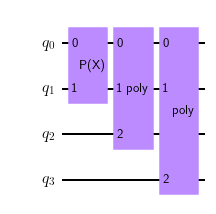

In [37]:
u = MultivariateGCI_sr(n_z, z_max, p_zeros, rhos, F_values[1])
u = MultivariateGCI_mr(n_z, z_max, p_zeros, rhos, F_values)

# from qiskit_finance.circuit.library import GaussianConditionalIndependenceModel as GCI

# u = GCI(n_z, z_max, p_zeros, rhos)

# print(u.decompose().draw(output='latex_source'))
u.decompose().draw("mpl", filename='Images/u_circuit.svg')

## Uncertainty model testing

Expected Loss E[L]:                8243.3829
Value at Risk VaR[L]:              54807.9414


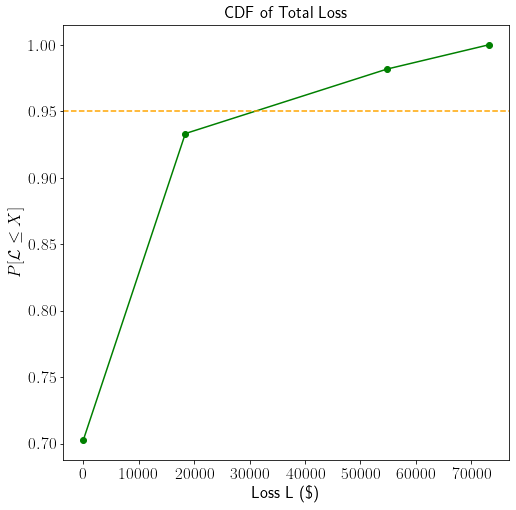

array([0.7026144 , 0.93317148, 0.98169751, 1.        ])

In [38]:
# run the circuit and analyze the results
job = execute(u, backend=Aer.get_backend('statevector_simulator'),) # n_shots=n_shots)

# analyze uncertainty circuit and determine exact solutions
p_z = np.zeros(2**n_z)
p_default = np.zeros(K)
values = []
probabilities = []
num_qubits = u.num_qubits
for i, a in enumerate(np.array(job.result().get_statevector())):
    
    # get binary representation
    b = ('{0:0%sb}' % num_qubits).format(i)
    prob = np.abs(a)**2
    
    # extract value of Z and corresponding probability    
    i_normal = int(b[-n_z:], 2)
    p_z[i_normal] += prob

    # determine overall default probability for k 
    loss = 0
    for k in range(K):
        if b[K - k - 1] == '1':
            p_default[k] += prob
            loss += lgd[k]
    values += [loss]
    probabilities += [prob]   

values = np.array(values)
probabilities = np.array(probabilities)
    
expected_loss = np.dot(values, probabilities)

losses = np.sort(np.unique(values))
pdf = np.zeros(len(losses))
for i, v in enumerate(losses):
    pdf[i] += sum(probabilities[values == v])
cdf = np.cumsum(pdf)

i_var = np.argmax(cdf >= 1-alpha_var)
exact_var = losses[i_var]

print('Expected Loss E[L]:                %.4f' % expected_loss)
print('Value at Risk VaR[L]:              %.4f' % exact_var)

# plot loss CDF
plt.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"] = (8, 8)
plt.plot(np.sort(np.unique(losses)), cdf, 'o-g')
plt.axhline(1-alpha_var, color="orange", linestyle="--")
   
plt.xlabel("Loss L (\$)", size=17)
plt.ylabel(r'$P[\mathcal{L} \leq X]$', size=17) 
plt.title ("CDF of Total Loss", size=17)
plt.xticks(size=17) # plt.xticks(np.sort(np.unique(losses)), np.sort(np.unique(losses)), size=17)
plt.yticks(size=17)
plt.savefig('Images/cdf.svg', dpi=400, bbox_inches = "tight")
plt.show()
cdf

In [39]:
def mapping(decimal_number):
    b = ('{0:0%sb}' % K).format(decimal_number)
    #print(b)
    losses = [loss for i, loss in enumerate(lgd[::-1]) if b[i]=='1']
    #print(losses)
    total_loss = sum(losses)
    return total_loss

def find_breakpoint(x_eval):
    for el in range(0,2**K):
        if mapping(el) <= x_eval:
            if mapping(el+1) >= x_eval:
                return el
    return 0

depth = 'e_loss'

In [40]:
if depth == 'e_loss':
    # define linear objective function for expected loss
    breakpoints = list(range(0,2**K))
    slopes = [0]*len(breakpoints)
    offsets = [mapping(el) for el in breakpoints]
    f_min = 0
    f_max = sum(lgd)
    c_approx = 0.01

    objective_e_loss = LinearAmplitudeFunction(
        K,
        slope=slopes, 
        offset=offsets, 
        # max value that can be reached by the qubit register (will not always be reached)
        domain=(0, 2**K-1),  
        image=(f_min, f_max),
        rescaling_factor=c_approx,
        breakpoints=breakpoints
    )

In [41]:
# from qiskit.circuit.library import WeightedAdder

# agg = WeightedAdder(n_z + K, [0] * n_z + lgd)

# # define linear objective function
# breakpoints = [0]
# slopes = [1]
# offsets = [0]
# f_min = 0
# f_max = sum(lgd)
# c_approx = 0.25

# objective_loss = LinearAmplitudeFunction(
#     agg.num_sum_qubits,
#     slope=slopes,
#     offset=offsets,
#     # max value that can be reached by the qubit register (will not always be reached)
#     domain=(0, 2 ** agg.num_sum_qubits - 1),
#     image=(f_min, f_max),
#     rescaling_factor=c_approx,
#     breakpoints=breakpoints,
# )

## Testing without QAE

In [9]:
from qiskit.circuit.library import LinearAmplitudeFunction


def get_cdf_circuit(x_eval):
    
    # define linear objective function for cdf
    breakpoints = list(range(0,2**K))
    slopes = [0]*len(breakpoints)
    # print(values)
    offsets = [1 if mapping(el)<=x_eval else 0 for el in breakpoints]
    f_min = 0
    f_max = 1
    c_approx = 0.01
    
    objective = LinearAmplitudeFunction(
        K,
        slope=slopes, 
        offset=offsets, 
        # max value that can be reached by the qubit register (will not always be reached)
        domain=(0, 2**K-1),  
        image=(f_min, f_max),
        rescaling_factor=c_approx,
        breakpoints=breakpoints
    )

    # define the registers for convenience and readability
    qr_state = QuantumRegister(u.num_qubits, 'state')
    qr_obj = QuantumRegister(1, 'objective')
    ar = QuantumRegister(objective.num_ancillas, "work")  # additional qubits

    # define the circuit
    state_preparation = QuantumCircuit(qr_state, qr_obj, ar, name='A')

    # load the random variable
    state_preparation.append(u.to_gate(), qr_state)

    # linear objective function (does aggregation and comparison)
    if depth == 'e_loss':
        state_preparation.append(objective_e_loss.to_gate(), qr_state[-K:] + qr_obj[:] + ar[:])
        return state_preparation, objective_e_loss
    else:
        state_preparation.append(objective.to_gate(), qr_state[-K:] + qr_obj[:] + ar[:])
        return state_preparation, objective
    
example = 0
state_preparation, objective = get_cdf_circuit(example)
job = execute(state_preparation, backend=Aer.get_backend('statevector_simulator'))

# evaluate resulting statevector
var_prob = 0
for i, a in enumerate(np.array(job.result().get_statevector())):
    b = ('{0:0%sb}' % (u.num_qubits + 1)).format(i)[-(u.num_qubits + 1):]
    prob = np.abs(a)**2
    if b[0] == '1':
        var_prob += prob
if depth == 'e_loss':
    print('Operator Expected Loss' + ' = %.4f' % objective.post_processing(var_prob), var_prob)
else:
    print('Operator CDF(%s)' % example + ' = %.4f' % objective.post_processing(var_prob))
state_preparation.draw()
# objective.decompose().decompose().draw()

Operator Expected Loss = 8244.4468 0.49391484094411564


┌───────┐      
  state_0: ┤0      ├──────
           │       │      
  state_1: ┤1      ├──────
           │  P(X) │┌────┐
  state_2: ┤2      ├┤0   ├
           │       ││    │
  state_3: ┤3      ├┤1   ├
           └───────┘│    │
objective: ─────────┤2 F ├
                    │    │
   work_0: ─────────┤3   ├
                    │    │
   work_1: ─────────┤4   ├
                    └────┘

In [42]:
np.array(job.result().get_statevector())

array([0.19915297+0.j, 0.52910695+0.j, 0.5677342 +0.j, 0.24632542+0.j,
       0.14888641+0.j, 0.33248589+0.j, 0.29525796+0.j, 0.10327527+0.j,
       0.08191289+0.j, 0.16332878+0.j, 0.11972758+0.j, 0.02837818+0.j,
       0.06123793+0.j, 0.10263429+0.j, 0.06226597+0.j, 0.01189794+0.j])

## Experiments
### Setup

In [10]:
import time
# set target precision and confidence level
epsilon = 0.01/6
alpha = 0.05/6

simulated = True
optimization_level = 1
n_shots = 2048

# get backend
backend_name = 'ibm_perth'
try:
    provider = IBMQ.get_provider(hub='ibm-q-research-2', group='politecnico-tor-1', project='main')
except:
    IBMQ.load_account()
    provider = IBMQ.get_provider(hub='ibm-q-research-2', group='politecnico-tor-1', project='main')
    
backend = provider.get_backend(backend_name)

qi_ideal = QuantumInstance(Aer.get_backend('qasm_simulator'), shots=n_shots, 
                           optimization_level=optimization_level, seed_transpiler=42)

if simulated == False:
    qi_noise = QuantumInstance(backend, shots=n_shots, 
                            optimization_level=optimization_level, seed_transpiler=42)
                            
else:
    noise_model = NoiseModel.from_backend(backend)
    # Get coupling map from backend
    coupling_map = backend.configuration().coupling_map
    # Get basis gates from noise model
    basis_gates = noise_model.basis_gates

    qi_noise = QuantumInstance(provider.get_backend('ibmq_qasm_simulator'), shots=n_shots, 
                           optimization_level=optimization_level, seed_transpiler=42,
                           noise_model=noise_model, coupling_map=coupling_map, basis_gates=basis_gates)

### Running and saving

In [11]:
if depth == 'e_loss':
    for i in range(1):
        now = datetime.now(tz=pytz.timezone("Europe/Rome"))

        problem = EstimationProblem(state_preparation=state_preparation,
                                    objective_qubits=[u.num_qubits],
                                    post_processing=objective.post_processing)
        # construct amplitude estimation and run
        ae = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi_ideal)
        ideal_result = ae.estimate(problem)

        # print results
        conf_int_ideal = np.array(ideal_result.confidence_interval_processed)
        result_ideal_processed = ideal_result.estimation_processed

        print("result with no noise:", result_ideal_processed)


        # problem = EstimationProblem(state_preparation=state_preparation,
        #                             objective_qubits=[u.num_qubits],
        #                             post_processing=objective.post_processing)
        # # construct amplitude estimation and run
        # ae = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi_noise)
        # noisy_result = ae.estimate(problem)

        # # print results
        # conf_int_noisy = np.array(noisy_result.confidence_interval_processed)
        # result_noisy_processed = noisy_result.estimation_processed
        
        # print("\nresult with noise:", result_noisy_processed)
        # print("\n\n")

        # with open('Data/experimental_results.csv', 'a+') as f:  
        #     f.write(f"{result_ideal_processed}, {result_noisy_processed}, simulated = {simulated}, {backend_name}, {now}\n")

result with no noise: 8366.129711689638


In [12]:
# noisy_result.num_oracle_queries
# ideal_result.num_oracle_queries
if depth == 'e_loss':
    from qiskit.visualization import plot_circuit_layout

    ae_circuit = ae.construct_circuit(problem, k=1)
    tr_ae_circuit = transpile(ae_circuit, optimization_level=optimization_level, backend=backend, seed_transpiler=42)
    
    # Return circuit depth (i.e., length of critical path).
    print(tr_ae_circuit.depth())
    # Returns total number of instructions in circuit.
    print(tr_ae_circuit.size()) 

    plot_circuit_layout(tr_ae_circuit, backend)

1923
2674


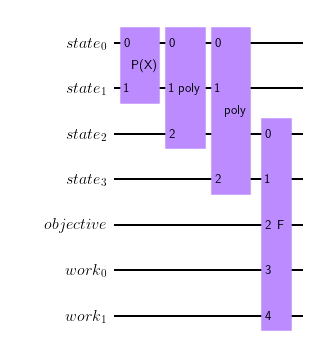

In [13]:
state_preparation.decompose().decompose().draw("mpl")

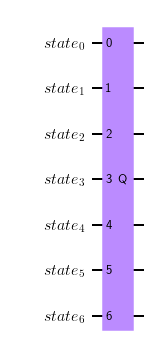

In [44]:
problem.grover_operator.draw("mpl")

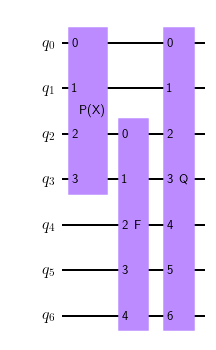

In [45]:
ae_circuit.decompose().draw("mpl")


In [16]:
# oracle = QuantumCircuit(8)
# oracle.z(7)  # the qubit state |1> is the good state
# grover_op = GroverOperator(oracle, state_preparation)
# grover_op.decompose().draw()

In [17]:
oracle2 = QuantumCircuit(7)
#oracle.z(6)  # the qubit state |1> is the good state
grover_op2 = GroverOperator(oracle2, state_preparation)
grover_op2.decompose().draw()

global phase: π
                  ┌──────────┐┌───┐     ┌───┐┌───────┐      
state_0: ─────────┤0         ├┤ X ├──■──┤ X ├┤0      ├──────
                  │          │├───┤  │  ├───┤│       │      
state_1: ─────────┤1         ├┤ X ├──■──┤ X ├┤1      ├──────
         ┌───────┐│  P(X)_dg │├───┤  │  ├───┤│  P(X) │┌────┐
state_2: ┤0      ├┤2         ├┤ X ├──■──┤ X ├┤2      ├┤0   ├
         │       ││          │├───┤  │  ├───┤│       ││    │
state_3: ┤1      ├┤3         ├┤ X ├──■──┤ X ├┤3      ├┤1   ├
         │       │└──┬───┬───┘└───┘  │  ├───┤└───────┘│    │
state_4: ┤2 F_dg ├───┤ X ├───────────■──┤ X ├─────────┤2 F ├
         │       │   ├───┤           │  ├───┤         │    │
state_5: ┤3      ├───┤ X ├───────────■──┤ X ├─────────┤3   ├
         │       │   ├───┤    ┌───┐┌─┴─┐├───┤  ┌───┐  │    │
state_6: ┤4      ├───┤ X ├────┤ H ├┤ X ├┤ H ├──┤ X ├──┤4   ├
         └───────┘   └───┘    └───┘└───┘└───┘  └───┘  └────┘

In [33]:
from collections import OrderedDict
counts = {"000":224, "001":100, "010":700}
m=3
measurements = OrderedDict()
samples = OrderedDict()
for state, count in counts.items():
    y = int(state.replace(" ", "")[: m][::-1], 2)
    probability = count / 1024
    measurements[y] = probability
    a = np.round(np.power(np.sin(y * np.pi / 2**m), 2), decimals=7)
    print(np.sin(y * np.pi / 2**m))
    samples[a] = samples.get(a, 0.0) + probability
print(measurements, samples)

0.0
1.0
0.7071067811865476
OrderedDict([(0, 0.21875), (4, 0.09765625), (2, 0.68359375)]) OrderedDict([(0.0, 0.21875), (1.0, 0.09765625), (0.5, 0.68359375)])


Operator Expected Loss = 46954.6276 0.5022200000000009


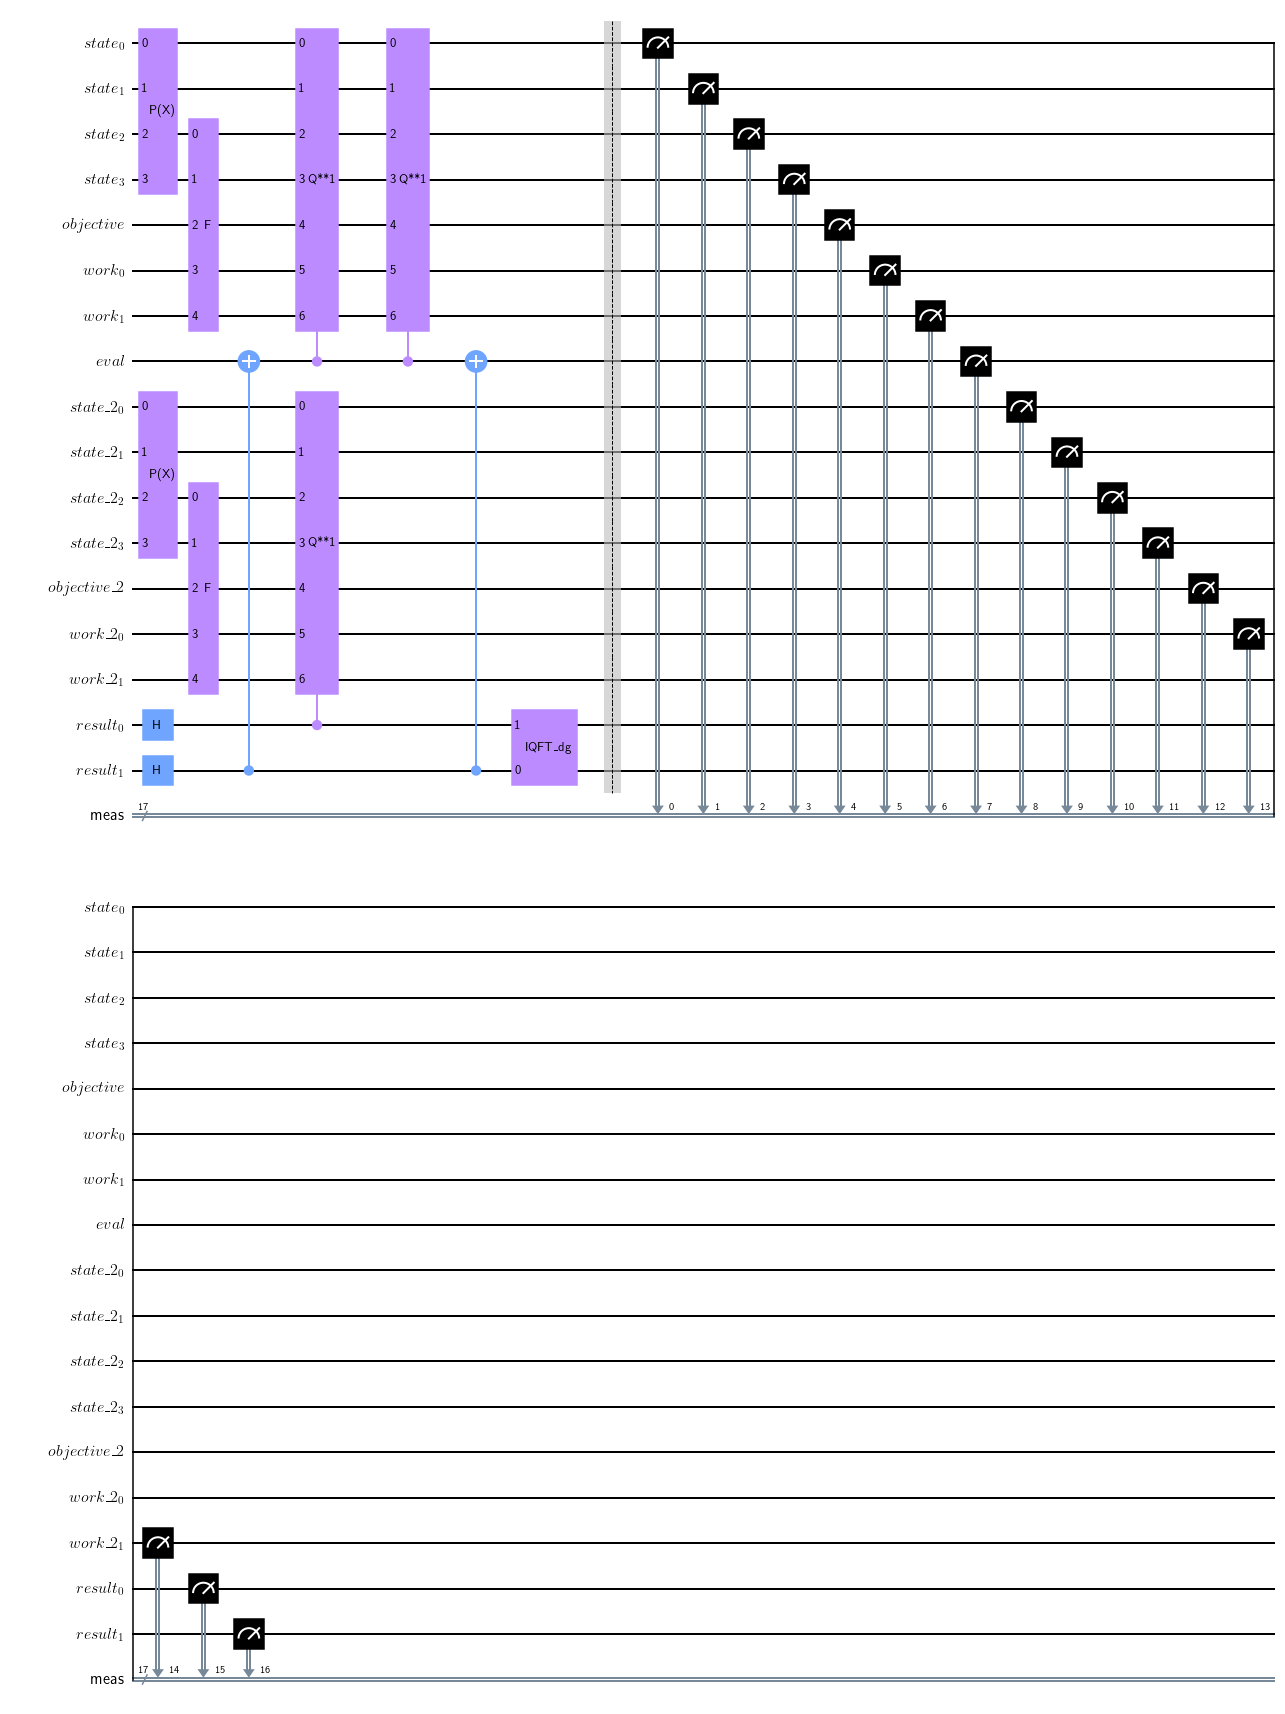

In [43]:
iqft = QFT(2, inverse=True, do_swaps=False).reverse_bits()
def get_parallelized_circuit():
    
    # define the registers for convenience and readability
    qr_state = QuantumRegister(u.num_qubits, 'state')
    qr_obj = QuantumRegister(1, 'objective')
    ar = QuantumRegister(objective.num_ancillas, "work")  # additional qubits

    qr_state2 = QuantumRegister(u.num_qubits, 'state_2')
    qr_obj2 = QuantumRegister(1, 'objective_2')
    ar2 = QuantumRegister(objective.num_ancillas, "work_2")  # additional qubits

    qr_result = QuantumRegister(2, 'result')
    qr_eval = QuantumRegister(1, 'eval')

    # define the circuit
    state_preparation = QuantumCircuit(qr_state, qr_obj, ar, qr_eval, qr_state2, qr_obj2, ar2, qr_result, name='A')

    state_preparation.h(qr_result[0])
    state_preparation.h(qr_result[1])  # hadamards on evaluation qubits
    # state_preparation.h(qr_result[1])

    # load the random variable
    state_preparation.append(u.to_gate(), qr_state)
    state_preparation.append(u.to_gate(), qr_state2)

    # state_preparation.cx(qr_result[0], qr_eval[0])



    # linear objective function (does aggregation and comparison)
    state_preparation.append(objective_e_loss.to_gate(), qr_state[-K:] + qr_obj[:] + ar[:])
    state_preparation.append(objective_e_loss.to_gate(), qr_state2[-K:] + qr_obj2[:] + ar2[:])
    state_preparation.cx(qr_result[1], qr_eval[0])
    # state_preparation.append(problem.grover_operator.to_gate(), qr_state[:] + qr_obj[:] + ar[:])
    

    state_preparation.compose(grover_op2.power(2**0).control(), qubits=qr_eval[:]+qr_state[:] + qr_obj[:] + ar[:], inplace=True)
    state_preparation.compose(grover_op2.power(2**0).control(), qubits=qr_eval[:]+qr_state[:] + qr_obj[:] + ar[:], inplace=True)
    state_preparation.compose(grover_op2.power(2**0).control(), qubits=qr_result[:1]+qr_state2[:] + qr_obj2[:] + ar2[:], inplace=True)
    state_preparation.cx(qr_result[1], qr_eval[0])
    state_preparation.compose(iqft, qubits=qr_result[:], inplace=True)
    
    # state_preparation.append(qpe.to_gate(), qr_eval[:] + qr_state2[:] + qr_obj2[:] + ar2[:])
    # state_preparation.cx(qr_result[0], qr_result[0])
    state_preparation.measure_all()

    return state_preparation, objective_e_loss

    
state_preparation2, objective = get_parallelized_circuit()
job = execute(state_preparation2, backend=Aer.get_backend('qasm_simulator'), shots=50000)

# evaluate resulting statevector
var_prob = 0
# for i, a in enumerate(np.array(job.result().get_counts())):
#     b = ('{0:0%sb}' % (u.num_qubits + 1)).format(i)[-(u.num_qubits + 1):]
#     if i==0:
#         print(b)
#     prob = np.abs(a)**2
#     if b[0] == '1':
#         var_prob += prob
for i in job.result().get_counts():
    a = job.result().get_counts()[i]

    prob = a/50000
    if i[15] == '1':
        var_prob += prob

print('Operator Expected Loss' + ' = %.4f' % objective.post_processing(var_prob), var_prob)

state_preparation2.draw("mpl")
# objective.decompose().decompose().draw()

Non puoi scendere sotto i 1000, se ti servono per k=1. Cutting?